# Intrinsic Few-Shot Hardness of Jailbreaking Datasets

In this notebook, I'll be attempting to replicate the results presented in the
paper _On Measuring the Intrinsic Few-Shot Hardness of Datasets_, specifically
to determine whether the use of a _jailbreaking_ dataset produces results that
are in line with their own databases. The authors of the paper collect several
tasks from widely used datasets that, in their view, particularly reflect
few-shot type tasks. Since we argue that jailbreaking is a few-shot learning
task, we would expect similar results.

Since their results are based on the correlation of method-specific few-shot
hardness between different tasks, we need more tasks to determine whether our
results are in line with theirs. Therefore, we will identify various methods of
jailbreaking, construct a database on those and investigate the degree of their
correlation with the rest of the results. ==One method of determining whether
this (or any other) point is an outlier is the Z-score, but I'll have to
investigate different methods.==

In [1]:
async def expose_jupyter_server(expose=False):
    """
    Expose Jupyter server running on Google Colab via ngrok. Not executed by
    default to avoid exposing the server unintentionally. To expose the server,
    set `expose` to `True` and call the function.
    """
    if not expose:
        print("Not exposing Jupyter server.")
        return
    
    try:
        from google.colab import userdata
        import re
    except ImportError:
        print("Not running on Google Colab! Not exposing Jupyter server.")
        return

    # Install jupyterlab and ngrok
    !pip install jupyterlab==2.2.9 ngrok -q

    # Run jupyterlab in background
    !nohup jupyter lab --no-browser --port=8888 --ip=0.0.0.0 &

    with open("nohup.out", "r") as file:
        match = None
        while not match:
            content = file.read()
            match = re.findall("\?token=.*", content)
        token = match[-1]

    # Make jupyterlab accessible via ngrok
    import ngrok

    listener = await ngrok.forward(
        8888, 
        # domain=userdata.get('NGROKDOMAIN'), 
        authtoken=userdata.get("NGROKTOKEN")
    )
    print("Connect to URL:", listener.url() + token)

await expose_jupyter_server()

Not exposing Jupyter server.


In [2]:
import os
import sys

def in_colab():
    return "google.colab" in sys.modules

# conda is required by default because we
# can avoid clashing packages. Please use
# a new environment for this project with
# python 3.8. Exception is google colab
# since it doesn't run with anything but
# the default conda environment.
if not in_colab():
    assert os.environ["CONDA_DEFAULT_ENV"] == "ifh"
    assert sys.version_info[:2] == (3, 10)

rng_seed = 42

In [3]:
import sys
import shutil

def has_conda():
    return shutil.which("conda") is not None

def install_conda():
    !pip install -q condacolab
    import condacolab
    condacolab.install()

if not has_conda():
    if "google.colab" in sys.modules:
        install_conda()
    else:
        raise RuntimeError("""
            Conda not found, and cannot be automatically installed unless
            in a Google Colab environment. Please install conda or launch
            in Google Colab.
        """)

In [4]:
!pip install -q datasets

 ______________________________________ 
/ Ray's Rule of Precision:             \
|                                      |
| Measure with a micrometer. Mark with |
\ chalk. Cut with an axe.              /
 -------------------------------------- 
        \   ^__^
         \  (oo)\_______
            (__)\       )\/\
                ||----w |
                ||     ||


## Methodology

### Reconstructing the Databases

First, we reconstruct the databases as described in the paper which are referred
to FS-GLUE and FS-NLI. For starters, we will consider the FS-GLUE dataset, as
this only concerns a subset of the GLUE and SuperGLUE datasets. These are:

- CoLA (Warstadt et al., 2018)
- MRPC (Dolan and Brockett, 2005)
- QQP (Wang et al., 2017)
- MNLI (Williams et al., 2018)
- QNLI (Rajpurkar et al., 2016)
- RTE (Dagan et al., 2010)
- SST-2 (Socher et al., 2013)

and

- BoolQ (Clark et al., 2019)
- CB (de Marneffe et al., 2019)
- COPA (Roemmele et al., 2011)
- WiC

for GLUE and SuperGLUE respectively.

In [5]:
try:
    import data

    data.download_and_prepare(
        dataset="all",
        fine_tuner="none"
    )
except ImportError as e:
    # download data.py from the github repository
    if not os.path.exists("data.py"):
        !wget -q "https://raw.githubusercontent.com/cochaviz/mep/experiments/src/replicating_ifh/data.py"
        print("Downloaded data.py from the repository. Please run the cell again.")
    else:
        print(e)

/home/zohar/.conda/envs/ifh/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Datasets: ['fs_glue', 'fs_nli']
Datasets already exist in /home/zohar/Documents/Study/msc/y2/mep/src/replicating_ifh/data/fs_glue/default.
Parsing datasets...
Fine-tuners: []
Done.


### Reconstructing the Fine-Tuning Methods

Secondly, we will set up an environment in which we can easily choose
fine-tuning methods, models, and the dataset on which we would like to perform
that fine-tuning. In the paper, they consider three different categories of
fine-tuning, each with their respective fine-tuning methods:

- _Prompt-based_:
  - LMBFF
  - AdaPET
  - Null Prompts
  - Prompt-Bitfit
- _Light-weight_:
  - Prefix Tuning
  - Compacter

In [6]:
try: 
    import fine_tuners

    fine_tuners.download_and_prepare(
        fine_tuner="all", 
        remote=True
    )
except ImportError:
    # download data.py from the github repository
    if not os.path.exists("adapet.py"):
        !wget -q "https://raw.githubusercontent.com/cochaviz/mep/experiments/src/replicating_ifh/fine_tuners.py"
        print("Downloaded data.py from the repository. Please run the cell again.")
    else:
        print(e)

fine_tuners directory already exists.
Setting up: lmbff...
Setup already exists: lmbff... Check logs.
Setting up: adapet...
Setup already exists: adapet... Check logs.


In [7]:
data.download_and_prepare(
    dataset="none",
    fine_tuner="all"
)

Datasets: []
Parsing datasets...
Fine-tuners: ['lmbff', 'adapet']
[setup:parse:lmbff] Directory '/home/zohar/Documents/Study/msc/y2/mep/src/replicating_ifh/data/fs_glue/lmbff' already exists. If you'd like to re-run this function, please remove the directory first.
[setup:parse:adapet] Directory '/home/zohar/Documents/Study/msc/y2/mep/src/replicating_ifh/data/fs_glue/adapet' already exists. If you'd like to re-run this function, please remove the directory first.
Done.


In [8]:
import subprocess
import json
from typing import Any

class FineTuner():
    task_mapping = {
        "cola": "CoLA",
        "mnli": "MNLI",
        "mrpc": "MRPC",
        "qqp": "QQP",
        "qnli": "QNLI",
        "rte": "RTE",
        "sst2": "SST-2",
        "boolq": "BoolQ",
        "cb": "CB",
        "copa": "COPA",
        "wic": "WiC"
    }
    
    def __init__(self, name: str, default_config: dict[str, Any]) -> None:
        self.name = name 
        self.location = f"fine_tuners/{name}"
        self.config: dict[str, Any] = default_config
    
    def tune(self, model_path: str, task_name: str, hide_output: bool=False, **kwargs) -> str:
        raise NotImplementedError("Subclasses must implement this method.") 

    def eval(self, model_path: str, task_name: str, hide_output: bool=False, **kwargs) -> str:
        raise NotImplementedError("Subclasses must implement this method.")
       
    def _exec_tuning(self, train: list[str], model: str, task_name: str, hide_output: bool=True) -> None: 
        print(f"[{self.name}] Started finetuning on task", task_name, "with model", model + ".")

        if hide_output:
            try:
                subprocess.run(train, cwd=self.location, check=True)
            except subprocess.CalledProcessError as e:
                print(f"[{self.name}] Error during finetuning! Try running with `hide_output=False` to see the error.")
                return
        else:
            !{" ".join([ "cd", self.location, "&&", *train ])}

        print(f"[{self.name}] Finished finetuning!")

    def _write_config(self) -> None:
        with open(f"{self.location}/auto_config.json", "w") as file:
            json.dump(self.config, file)
   
    def __repr__(self) -> str:
        return f"FineTuner({self.name})"

    def check_supported_task(self, task_name: str) -> bool:
        return task_name in self.task_mapping


### LMBFF

In [9]:
class LMBFF(FineTuner):

    task_mapping = {
        # default tasks
        "cola": "CoLA",
        "mrpc": "MRPC",
        "qqp": "QQP",
        "mnli": "MNLI",
        "qnli": "QNLI",
        "rte": "RTE",
        "sst2": "SST-2",
        "cr": "cr",
        # exteded tasks
        "boolq": "boolq",
    }

    def __init__(self) -> None:
        super().__init__("lmbff", {
            "task_name": None,
            "data_dir": None,
            "overwrite_output_dir": True,
            "do_train": True,
            "do_eval": True,
            "do_predict": True,
            "evaluate_during_training": True,
            "model_name_or_path": None,
            "few_shot_type": "prompt",
            "num_k": 8, # not sure about this
            "max_steps": 1000,
            "eval_steps": 100,
            "per_device_train_batch_size": 2,
            "learning_rate": 1e-5,
            "num_train_epochs": 0,
            "output_dir": None,
            "seed": rng_seed,
            "template": "*cls**sent_0*_It_was*mask*.*sep+*",
            "mapping": "{'0':'terrible','1':'great'}",
            "num_sample": 16
        })

    def tune(self, model_path, task_name, id="test", hide_output=True, **kwargs) -> str:
        if not self.check_supported_task(task_name):
            raise ValueError(f"Task {task_name} not supported by LM-BFF.")
        
        task_name = self.task_mapping[task_name]

        self.config["task_name"] = task_name
        self.config["model_name_or_path"] = model_path
        self.config["output_dir"] = f"result/{model_path}/{id}/{task_name}"
        self.config["data_dir"] = f"data/k-shot/{task_name.upper()}/16-42"
        self.config.update(kwargs)
        self._write_config()

        train = [ "conda", "run", "-n", "lmbff", "python", "run.py", "auto_config.json" ]
        self._exec_tuning(train, model_path, task_name, hide_output)

        return self.config["output_dir"]

### AdaPET

In [10]:
import glob

class ADAPET(FineTuner):
    task_mapping = {
        # basic tasks
        "boolq": "BoolQ",
        "cb": "CB",
        "copa": "COPA",
        "wic": "WiC",
        "mrpc": "MRPC",
        "rte": "RTE",
        # externded tasks
        # "sst2": "sst2"
    }

    def __init__(self) -> None:
        super().__init__("adapet", {
            "pretrained_weight": None,
            "dataset": None,
            "max_text_length": 256,
            "batch_size": 1,
            "eval_batch_size": 1,
            "num_batches": 64,
            "max_num_lbl_tok": 1,
            "eval_every": 16,
            "warmup_ratio": 0.06,
            "mask_alpha": 0.105,
            "grad_accumulation_factor": 16,
            "seed": rng_seed,
            "lr": 1e-5,
            "weight_decay": 1e-2,
            "pattern_idx": 1,
            "eval_train": True
        })

    def tune(self, model_path, task_name, hide_output: bool=True, **kwargs) -> str:
        if not self.check_supported_task(task_name):
            raise ValueError(f"Task {task_name} not supported by ADAPET.")

        task_name = self.task_mapping[task_name]

        self.config["pretrained_weight"] = model_path
        self.config["dataset"] = f"fewglue/{task_name}"
        self.config.update(kwargs)

        assert self.config["num_batches"] % self.config["eval_every"] == 0, \
            "num_batches must be divisible by eval_every."
        assert self.config["grad_accumulation_factor"] % self.config["eval_every"] == 0, \
            "grad_accumulation_factor must be divisible by eval_every."

        self._write_config()

        train = [ "conda", "run", "-n", "adapet", "python", "src/train.py", "-c", "auto_config.json" ]
        self._exec_tuning(train, model_path, task_name, hide_output=hide_output)

        try:
            # HACK: This is a hack to get the output path. The last directory in
            # the list is the latest one. They are sorted by datetime, but it's
            # hard to retrieve the latest one using the API.
            output_path = glob.glob(f"{self.name}/exp_out/fewglue/{task_name}/{model_path}/*")[-1]
        except IndexError:
            print(f"[{self.name}] Error during finetuning! Could not find output path. Try running with `hide_output=False` to see the error.")
            return

        return output_path

## Results

So while reproducing everything is now _technically_ possible (at the time of
writing I still have a bout 4 fine-tuning methods to fix, but I don't think that
should be a big problem), applying all the tasks to all the fine-tuners just
takes too much time. Therefore, I will only aggregate my own jailbreaking
examples and use that as a task to determine how that compares to the other
tasks.

This section covers how the authors processed their results. I will not use
their code one-to-one because I think it's very hard to read and understand.
Since I have to understand their analysis, I could just as well recreate it
to understand exactly what they are doing while making it more readable.

In [11]:
import json
import pandas as pd
import seaborn as sns
import numpy as np

sns.set_theme(context="notebook", style="whitegrid", palette="muted")

In [12]:
try:
    with open("intrinsic_fewshot_hardness/heatmap_raw_data.json","r",encoding="utf-8") as f:
        raw_data = json.load(f)
except FileNotFoundError e:
    # get content remotely from gist.githubusercontent.com
    raise e
   
# fine-tuning tasks performance
acc_raw = raw_data["output_collection"]
acc_baseline_raw = raw_data["majority_collection"]
acc_electra_raw = raw_data["output_collection_electra"]

# dataset metadata
n_samples_test = raw_data["testsize_collection"]

# final hidden layer data - data to calculate spread
all_dist_collections = raw_data["all_dist_collections"]

First, let's aggregate all the 'accuracy' data into a single dataframe.

In [13]:
# drop these as they are not 'accuracy of one model after finetuning'
# which is what we need
fine_tuned_acc = pd.DataFrame(acc_raw) \
    .drop(["sensitivity", "rda", "few-avg"], axis="columns") / 100.0

baseline_acc = pd.DataFrame(
    { "baseline": list(acc_baseline_raw.values()) }
    , index=list(acc_baseline_raw.keys()) )

# make sure all values are on a scale of [0.0, 1.0]
baseline_acc_scaled = baseline_acc.where(baseline_acc <= 1.0, baseline_acc / 100)
all_acc = pd.concat([fine_tuned_acc, baseline_acc_scaled], axis="columns")

# I'm not sure what to do with tasks that contain NaN values. They seem in
# appropriate to include since we cannot compare all of them with one another.
clean_acc = all_acc.dropna()

display(all_acc.head(10))


,manual,lmbff,nullp,bitfit,adapet,ptuning,adapter,compacter,roberta,roberta-zero,baseline
anaphora,0.5030,0.503,0.479,0.493,0.542,0.521,0.582,0.507,0.500,0.493,0.51
boolean,0.9830,0.697,0.717,0.742,0.820,0.806,0.936,0.722,0.726,0.629,0.73
comparative,0.5240,0.485,0.459,0.470,0.867,0.648,0.573,0.563,0.648,0.648,0.65
conditional,0.6210,0.977,0.717,0.680,1.000,0.662,1.000,0.662,0.662,0.662,0.66
counting,0.8500,0.852,0.819,0.858,0.938,0.905,0.894,0.796,0.662,0.338,0.66
event,0.6250,0.676,0.617,0.654,0.871,0.613,0.697,0.606,0.500,0.507,0.50
gender,0.5700,0.613,0.543,0.522,0.805,0.509,0.509,0.519,0.500,0.509,0.50
lexico_syntactic,0.6530,0.699,0.489,0.515,0.656,0.517,0.501,0.488,0.513,0.512,0.51
monotonicity,0.4830,0.782,0.611,0.578,0.801,0.694,0.670,0.556,0.671,0.329,0.67
monotonicity_simple,0.5715,0.725,0.629,0.590,0.566,0.675,0.666,0.667,0.667,0.332,0.67


### Method Specific Few-Shot Hardness

Here, we will define the _Method Specific Few-Shot Hardness_ (MFH) and perform
the experiments shown in the paper. That is, we will "report the average
spearman correlation between MFH values for all pairs of adapation methods for
every dataset". MFH is defined as "the classification accuracy of the adapted
model, normalized against the classification accuracy of the majority baseline":

$$
\mathrm{MFH}(\mathcal{D}, f, m) = \mathrm{acc}( f_m(\mathcal{D}_{ts}),
\mathcal{D}_{ts}) - \mathrm{acc}( \hat{y}_{majority}(\mathcal{D}_{ts}), \mathcal{D}_{ts} )
$$

Here, $\hat{y}_{majority}$, refers to 'an approximation of the classifier based
on majority vote'. This metric will, thus, determine the accuracy of the model
after fine-tuning on dataset $\mathcal{D}$. I'll be honest that I don't
understand what _hardness_ refers to, but I'll come back to the semantics of
hardness in a later section.

In [14]:
def df_with_columns(df: pd.DataFrame, columns: list[str] | None) -> pd.DataFrame:
    return df[df.columns[df.columns.isin(columns)]] if columns else df

def df_with_indexes(df: pd.DataFrame, indexes: list[str] | None) -> pd.DataFrame:
    return df.loc[df.index.isin(indexes)] if indexes else df

def df_with(df, 
            indexes: list[str] | None = None, 
            columns: list[str] | None = None
            ) -> pd.DataFrame:
    return df_with_indexes(df_with_columns(df, columns), indexes)

def mfh(data) -> pd.DataFrame:
    return data.sub(data["baseline"], axis="index").drop("baseline", axis="columns")

def mfh_avg(data, include_tasks: list[str] | None = None) -> pd.DataFrame:
    mfh_data = mfh(data)
    mfh_data = df_with_indexes(mfh_data, include_tasks)

    molten = mfh_data.melt(
        id_vars=None, 
        value_vars=mfh_data.columns.to_list(), 
        var_name="method", 
        value_name="acc_norm")
    return molten.groupby("method").mean()

all_mfh = mfh(all_acc)
clean_mfh = mfh(clean_acc)

# display("Average 'Method-Specific' Few-Shot Hardness on all tasks:")
display(all_mfh.head(10))
# display("Average 'Method-Specific' Few-Shot Hardness on 'clean' tasks:")
display(clean_mfh.head(10))

,manual,lmbff,nullp,bitfit,adapet,ptuning,adapter,compacter,roberta,roberta-zero
anaphora,-0.0070,-0.007,-0.031,-0.017,0.032,0.011,0.072,-0.003,-0.010,-0.017
boolean,0.2530,-0.033,-0.013,0.012,0.090,0.076,0.206,-0.008,-0.004,-0.101
comparative,-0.1260,-0.165,-0.191,-0.180,0.217,-0.002,-0.077,-0.087,-0.002,-0.002
conditional,-0.0390,0.317,0.057,0.020,0.340,0.002,0.340,0.002,0.002,0.002
counting,0.1900,0.192,0.159,0.198,0.278,0.245,0.234,0.136,0.002,-0.322
event,0.1250,0.176,0.117,0.154,0.371,0.113,0.197,0.106,0.000,0.007
gender,0.0700,0.113,0.043,0.022,0.305,0.009,0.009,0.019,0.000,0.009
lexico_syntactic,0.1430,0.189,-0.021,0.005,0.146,0.007,-0.009,-0.022,0.003,0.002
monotonicity,-0.1870,0.112,-0.059,-0.092,0.131,0.024,0.000,-0.114,0.001,-0.341
monotonicity_simple,-0.0985,0.055,-0.041,-0.080,-0.104,0.005,-0.004,-0.003,-0.003,-0.338


,manual,lmbff,nullp,bitfit,adapet,ptuning,adapter,compacter,roberta,roberta-zero
anaphora,-0.0070,-0.007,-0.031,-0.017,0.032,0.011,0.072,-0.003,-0.010,-0.017
boolean,0.2530,-0.033,-0.013,0.012,0.090,0.076,0.206,-0.008,-0.004,-0.101
comparative,-0.1260,-0.165,-0.191,-0.180,0.217,-0.002,-0.077,-0.087,-0.002,-0.002
conditional,-0.0390,0.317,0.057,0.020,0.340,0.002,0.340,0.002,0.002,0.002
counting,0.1900,0.192,0.159,0.198,0.278,0.245,0.234,0.136,0.002,-0.322
event,0.1250,0.176,0.117,0.154,0.371,0.113,0.197,0.106,0.000,0.007
gender,0.0700,0.113,0.043,0.022,0.305,0.009,0.009,0.019,0.000,0.009
lexico_syntactic,0.1430,0.189,-0.021,0.005,0.146,0.007,-0.009,-0.022,0.003,0.002
monotonicity,-0.1870,0.112,-0.059,-0.092,0.131,0.024,0.000,-0.114,0.001,-0.341
monotonicity_simple,-0.0985,0.055,-0.041,-0.080,-0.104,0.005,-0.004,-0.003,-0.003,-0.338


Now we want to determine how similarly methods have improved when considering
certain tasks. To do this, we calculate the _Spearman_ correlation coefficient
which determines the monotonic relation of two ranked lists. 

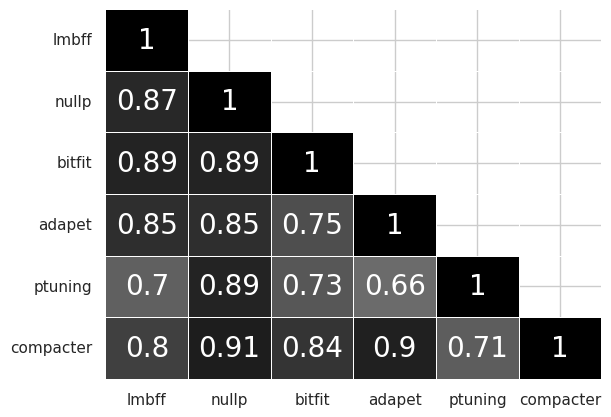

In [15]:
def draw_heatmap(df, **opts):
    sns.heatmap(
        df, annot=True, vmax=1, center=0.6, cbar=False, square=False,
        linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"fontsize":20},
        cmap="binary", **opts
    )

def draw_corr(df, method: str="spearman"):
    corr = df.corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    draw_heatmap(corr, mask=mask)

included_methods = ["lmbff", "nullp", "bitfit", 
                    "adapet", "ptuning", "compacter",
                    "baseline"]
included_tasks = ["cola", "sst2", "mrpc", "qqp", 
                  "mnli", "qnli", "rte", "boolq", 
                  "cb", "copa", "wic"]

min_acc = df_with(all_acc, indexes=included_tasks, columns=included_methods)
min_mfh = mfh(min_acc)

draw_corr(min_mfh)

Which is exactly the result as presented in their paper, but I'm not sure what
exactly this is telling us. Firstly, let's look at the scatterplot of one pair
with an explicitly high correlation: $\mathrm{compacter}$ and $\mathrm{nullp}$.

Spearman's correlation between 'compacter' and 'nullp': 0.9090909090909091


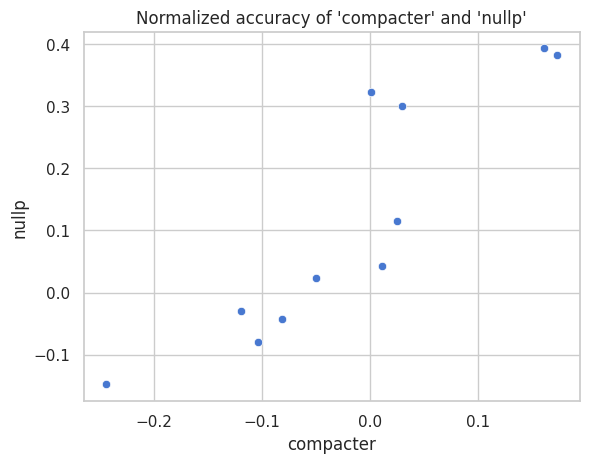

In [16]:
sns.scatterplot(
    data=min_mfh, x="compacter", y="nullp"
    ).set_title("Normalized accuracy of 'compacter' and 'nullp'")

corr = min_mfh.corr(method="spearman")["compacter"]["nullp"]
print("Spearman's correlation between 'compacter' and 'nullp':", corr)

We can see that, indeed, a monotonic correlation is there. Essentially, if we
see a strong correlation we can expect that models will improve similarly when
comparing one task with another. Not to the same magnitude, as different methods
might have slightly different success rates, but if certain tasks are
'significantly' harder than others, we would expect some monotonic relation when
the values are sorted. As can be seen above.

#### Detour - Improved Normalization of MFH

In the current normalization, improvements over the baseline are counted equal
regardless of the value of the baseline. This means that a 5% increase in a
baseline of 50% is equal to a 5% increase in a baseline of 90%. Considering the
asymptotic relation normally found in learning scenarios, this can introduce
inconsistencies when comparing normalized accuracies of methods on tasks with
different baseline values.

To reflect the characteristic of an asymptotic learning curve, I scale the
original normalization by the inverse of the baseline. That is:

$$
\frac{
    \mathrm{Accuracy} - \mathrm{Accuracy}_{\mathrm{base}}
}{
    1 - \mathrm{Accuracy}_{\mathrm{base}}
}
$$

Where $acc$ is the to be normalized accuracy and $acc_{base}$ the baseline
accuracy. This means that an accuracy of $1.0$ will remain as 'perfectly
accurate' regardless of the baseline, while values equal to the baseline will be
zero and accuracies under the baseline will still be zero. The characteristic of
values under the baseline leave something to be desired, but as we currently
have no combination of methods and tasks where that is the case, this does not
seem relevant to this particular use-case.

In [17]:
def mfh_imp(data) -> pd.DataFrame:
    """
    An improved version of the baseline accuracy where perfectly accurate
    is still 1.0, instead of 1 - baseline.
    """
    return mfh(data).div((1.0 - data["baseline"]), axis="index")

def mfh_avg(data, imp=False) -> pd.DataFrame:
    mfh_data = mfh(data) if not imp else mfh_imp(data)
    molten = mfh_data.melt(
        id_vars=None, 
        value_vars=mfh_data.columns.to_list(), 
        var_name="method", 
        value_name="acc_norm")
    return molten.groupby("method").mean()

<!-- We would expect this only to matter in task-to-task comparisons. In the case of
method-to-method comparisons, the baseline is equal and thus the scaling has no
effect on the normalized accuracy between methods. This means that if we
calculate the Pearson correlation between the different methods within a certain
task, we should expect the same results regardless of using `mfh` or `mfh_imp`. -->

Now, let's look at the same scatterplot and Spearman's correlation as before and see how it influenced the results.

Before, after, and difference between default and improved normalization:
0.9090909090909091 0.9545454545454546 -0.045454545454545525


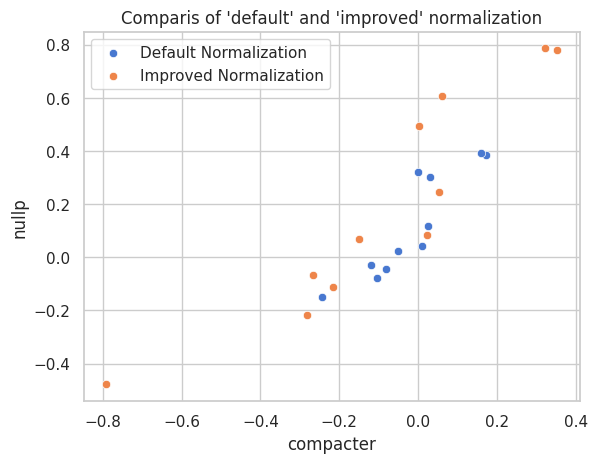

In [18]:
sns.scatterplot(data=mfh(min_acc), x="compacter", y="nullp", label="Default Normalization")
sns.scatterplot(
    data=mfh_imp(min_acc), x="compacter", y="nullp", label="Improved Normalization"
    ).set_title("Comparis of 'default' and 'improved' normalization")

corr_def = mfh(min_acc).corr(method="spearman")["compacter"]["nullp"]
corr_imp = mfh_imp(min_acc).corr(method="spearman")["compacter"]["nullp"]
print("Before, after, and difference between default and improved normalization:")
print(corr_def, corr_imp, corr_def - corr_imp)

And finally the heatmap discussed before.

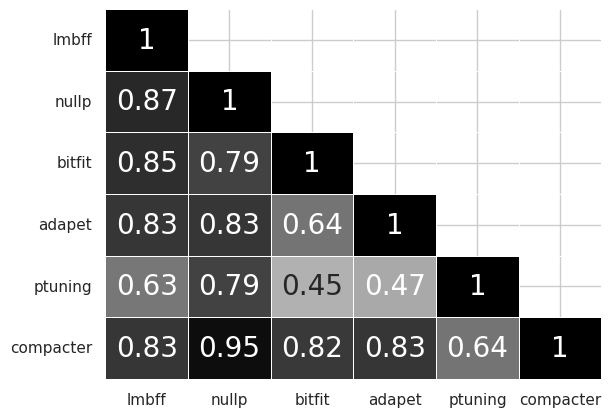

In [19]:
draw_corr(mfh_imp(min_acc))

#### Detour - Comparison of Fine-tuning Method Performance

In [20]:
not_improved = mfh(min_acc) < 0

print("How many tasks the methods have not improved upon over the baseline:")
not_improved.sum(axis="index")

How many tasks the methods have not improved upon over the baseline:


lmbff        3
nullp        4
bitfit       4
adapet       2
ptuning      1
compacter    5
dtype: int64

#### Detour - Dealing with Unevenly Incompletely Evaluated Tasks

Some of the tasks have not been evaluated with all the methods. It seems
inappropriate to include these in the analysis, or strange at the very least. To
determine whether it is important to distinguish between the 'clean' and 'dirty'
task sets (excluding and including the tasks in question respectively). If the
proportion of 'dirty' tasks is correlated with the difference in the MFH, we can
conclude that considering them should be important.

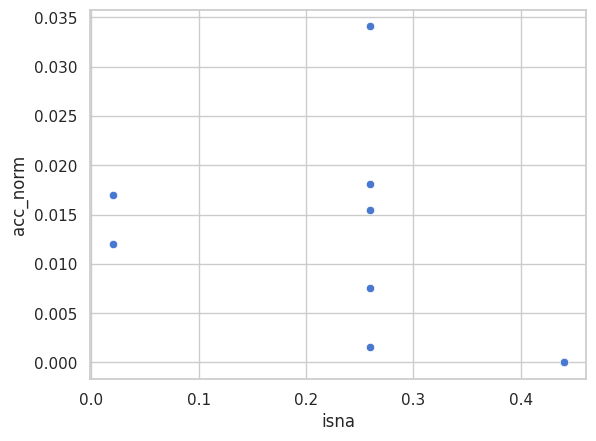

In [21]:
def isna_proportion(data: pd.DataFrame) -> pd.DataFrame:
    "returns the portion of NaN values in each column of the dataframe" 
    return pd.DataFrame({ "isna" : data.isnull().mean() }, index=data.columns.to_list())

diff_mfh = abs(mfh_avg(all_acc) - mfh_avg(clean_acc)).sort_values("acc_norm")
diff_isna = pd.concat([diff_mfh, isna_proportion(all_acc)], axis="columns")

_ = sns.scatterplot(diff_isna, y="acc_norm", x="isna")

However, it does not seem that this is the case. This is probably because I'm
misinterpreting some of the rows as tasks while they might not actually be as
such. This was a small experiment at the very beginning of the process. I'll
leave it in here, but can't, and won't, conclude anything from it.

### Intrinsic Few-Shot Hardness

Now that we have established some correlation between the different
methodologies - that is: there is a monotonic trend when comparing
the accuracy of these methods on different tasks - we would like to see in more
explicit terms that some tasks are indeed harder than others. To do this, the
authors establish a metric called the _Intrinsic Few-Shot Hardness_.

$$
\mathrm{IFH}(f, \mathcal{D}) = \frac
{
    \sum_{m\in\mathcal{M}}\mathrm{MFH}(\mathcal{D}, f, m)
}{
    | \mathcal{M} |
}
$$

This is essentially the average improvement we see in a certain task when
considering all the methods.

In [63]:
def ifh(data: pd.DataFrame, imp=False) -> pd.DataFrame:
    return pd.DataFrame(mfh(data).mean(axis="columns"), columns=["ifh"]) if not imp \
        else pd.DataFrame(mfh_imp(data).mean(axis="columns"), columns=["ifh"])

min_ifh = ifh(min_acc).sort_values("ifh")
min_ifh_imp = ifh(min_acc, imp=True).sort_values("ifh")

display(min_ifh)
display(min_ifh_imp)

,ifh
cola,-0.157467
qqp,-0.128633
copa,-0.035800
mrpc,0.012783
boolq,0.028833
wic,0.034433
rte,0.107583
mnli,0.188867
qnli,0.196183
sst2,0.290230


,ifh
cola,-0.509436
qqp,-0.349357
copa,-0.079556
mrpc,0.038046
wic,0.068867
boolq,0.076218
rte,0.227497
mnli,0.289628
qnli,0.396570
sst2,0.591305


While the paper only uses this metric to verify other results, we can
investigate whether their claim that different datasets (i.e. tasks) are
intrinsically harder than others holds using this metric. Firstly, we can look
at the distribution of the MFH per task and see how much they overlap.

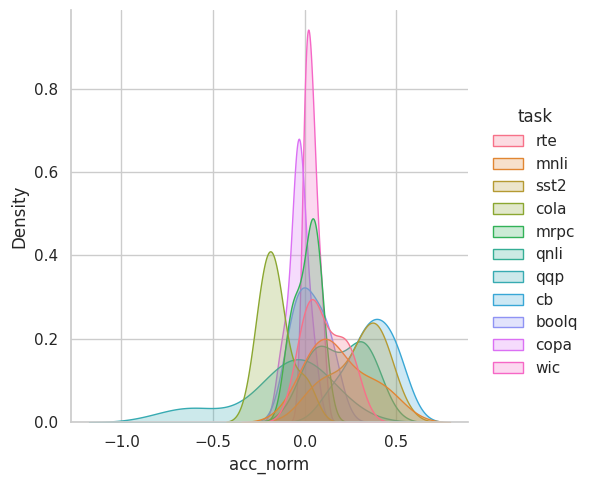

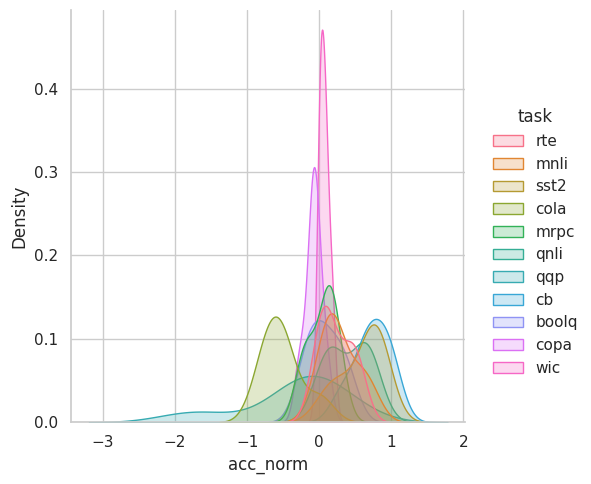

In [57]:
mfh_molt = mfh(min_acc).reset_index().rename(columns={"index": "task"}).melt(
    id_vars="task", value_vars=mfh(min_acc).columns.to_list(), 
    var_name="method", value_name="acc_norm"
)

mfh_molt_imp = mfh_imp(min_acc).reset_index().rename(columns={"index": "task"}).melt(
    id_vars="task", value_vars=mfh(min_acc).columns.to_list(), 
    var_name="method", value_name="acc_norm"
)


_ = sns.displot(data=mfh_molt, x="acc_norm", hue="task", kind="kde", fill=True)
_ = sns.displot(data=mfh_molt_imp, x="acc_norm", hue="task", kind="kde", fill=True)

In a way, this seems to suggest that, on average, there is barely any
improvement on most of the tasks. It seems like we can categorize them into
three groups, with one or two outliers:

    task method group  acc_norm
0    rte  lmbff     B   0.23790
1   mnli  lmbff     B   0.44870
2   sst2  lmbff     C   0.40253
3   cola  lmbff     A  -0.21790
4   mrpc  lmbff     B   0.08900
5   qnli  lmbff     E   0.31380
6    qqp  lmbff     D   0.02190
7     cb  lmbff     C   0.48180
8  boolq  lmbff     B   0.15280
9   copa  lmbff     B  -0.02480


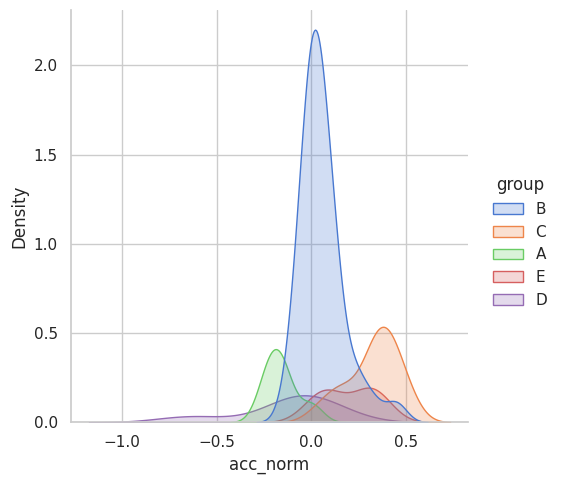

In [54]:
def get_label(task: str) -> str:
    # group_b = ["rte", "mrpc", "qqp", "boolq", "copa", "wic", "mnli"]
    # group_c = ["sst2", "cb"]
    # others = set(included_tasks) - set(group_a + group_b + group_c)

    groups = {
        "A": [ "cola" ], 
        "B": [ "rte", "mrpc", "boolq", "copa", "wic", "mnli" ], 
        "C": [ "sst2", "cb"], 
        "D": [ "qqp" ],
        "E": [ "qnli" ]
        }

    for label, tasks in groups.items():
        if task in tasks:
            return label
    return None

mfh_grouped = mfh_molt.assign(group=mfh_molt["task"].apply(get_label))

print(mfh_grouped.head(10))
sns.displot(data=mfh_grouped, x="acc_norm", hue="group", kind="kde", fill=True)